In [1]:
pip install biopython


Note: you may need to restart the kernel to use updated packages.


/mainfs/lyceum/avrv1n23/myenv/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Number of sequences: 6
Alignment length: 1323


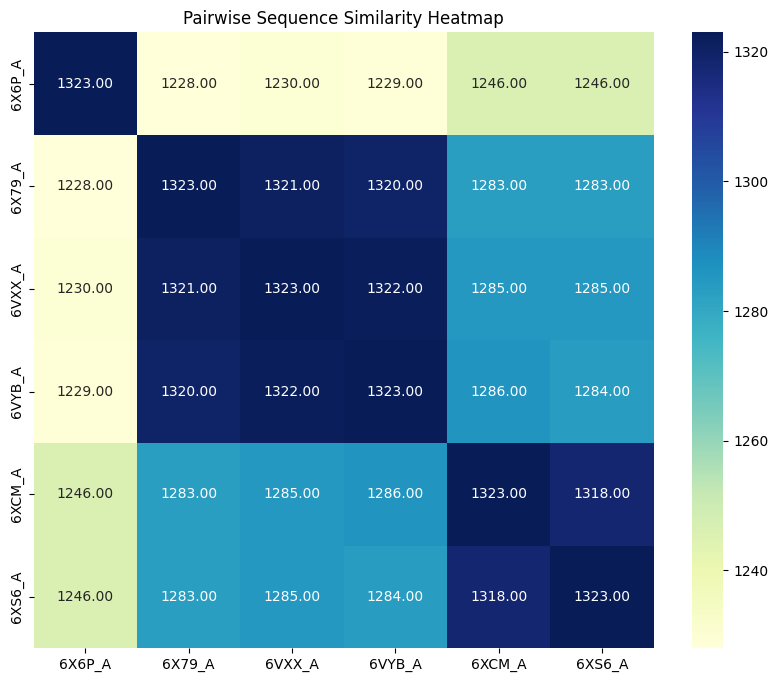

In [2]:
from Bio import AlignIO
from Bio import pairwise2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Read the MSA file
msa_file = "MSA.aln-clustal_num"
alignment = AlignIO.read(msa_file, "clustal")

# Print alignment details
print(f"Number of sequences: {len(alignment)}")
print(f"Alignment length: {alignment.get_alignment_length()}")

# Convert alignment to a list of sequences
sequences = [str(record.seq) for record in alignment]

# Function to calculate similarity score between two sequences
def calculate_similarity(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2)
    # Choose the highest score alignment
    best_alignment = max(alignments, key=lambda x: x[2])
    return best_alignment[2]  # Return the score

# Initialize a matrix to store similarity scores
num_sequences = len(sequences)
similarity_matrix = np.zeros((num_sequences, num_sequences))

# Calculate similarity scores
for i in range(num_sequences):
    for j in range(i, num_sequences):
        score = calculate_similarity(sequences[i], sequences[j])
        similarity_matrix[i, j] = score
        similarity_matrix[j, i] = score  # Symmetric matrix

# Create a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=[record.id for record in alignment], yticklabels=[record.id for record in alignment], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Pairwise Sequence Similarity Heatmap")
plt.show()


In [5]:
from Bio.PDB import PDBParser
from Bio.PDB.vectors import calc_dihedral
from Bio import AlignIO
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# Define the paths to your PDB files and MSA file
pdb_files = ["6vxx.pdb", "6vyb.pdb", "6x6p.pdb", "6x79.pdb", "6xcm.pdb", "6xs6.pdb"]
msa_file = "MSA.aln-clustal_num"

# Create a parser object
parser = PDBParser(QUIET=True)

# Read the MSA file
alignment = AlignIO.read(msa_file, "clustal")

# Function to convert three-letter codes to single-letter
def three_to_one_letter(residue_name):
    three_to_one = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C', 
        'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P', 
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    return three_to_one.get(residue_name, 'X')  # 'X' for unknown residues

# Lists to store the data
phi_angles = []
psi_angles = []
residue_ids = []
chain_ids = []
msa_columns = []

# Function to calculate phi and psi angles
def calculate_phi_psi(residues):
    phi_angles = []
    psi_angles = []
    for i in range(1, len(residues) - 2):  # Ensures there's enough room for indices i, i+1, i+2, i+3
        res1 = residues[i - 1]
        res2 = residues[i]
        res3 = residues[i + 1]
        res4 = residues[i + 2]
        
        # Ensure all required atoms are present
        if all(atom in res1 for atom in ['N', 'CA', 'C']) and all(atom in res2 for atom in ['N', 'CA', 'C']) and all(atom in res3 for atom in ['N', 'CA', 'C']) and all(atom in res4 for atom in ['N', 'CA', 'C']):
            # Calculate phi angle
            phi = calc_dihedral(
                res1['C'].get_vector(), 
                res2['N'].get_vector(), 
                res2['CA'].get_vector(), 
                res3['C'].get_vector()
            )
            phi_angles.append(np.degrees(phi))
            
            # Calculate psi angle
            psi = calc_dihedral(
                res2['N'].get_vector(), 
                res2['CA'].get_vector(), 
                res2['C'].get_vector(), 
                res3['N'].get_vector()
            )
            psi_angles.append(np.degrees(psi))
        else:
            phi_angles.append(np.nan)
            psi_angles.append(np.nan)
    
    return phi_angles, psi_angles



# Process each PDB file
for pdb_file in pdb_files:
    structure = parser.get_structure("SpikeGlycoprotein", pdb_file)
    
    # Iterate over all models in the structure (typically there's only one)
    for model in structure:
        # Iterate over all chains in the model
        for chain in model:
            if chain.id == 'A':  # Process chain A
                # Iterate over all residues in the chain
                residues = list(chain)
                
                # Calculate phi and psi angles
                phi_angles_chain, psi_angles_chain = calculate_phi_psi(residues)
                
                # Map residues to MSA and collect data
                for i in range(len(phi_angles_chain)):
                    residue_position = residues[i].id[1] - 1  # Assuming 1-based indexing
                    msa_residue = alignment[0][residue_position]  # Get the aligned residue from MSA
                    
                    chain_ids.append(chain.id)
                    residue_ids.append(residues[i].id[1])
                    phi_angles.append(phi_angles_chain[i])
                    psi_angles.append(psi_angles_chain[i])
                    msa_columns.append(msa_residue)

# Create a DataFrame for chain A
dihedral_dfa = pd.DataFrame({
    'Chain ID': chain_ids,
    'Residue ID': residue_ids,
    'Phi Angle': phi_angles,
    'Psi Angle': psi_angles,
    'MSA Residue': msa_columns
})

# Define the classification function based on phi and psi angles
def classify_secondary_structure(phi, psi):
    if -60 <= phi <= -45 and -60 <= psi <= -45:
        return 'Alpha Helix'
    elif (-150 <= phi <= -120 or 120 <= phi <= 150) and (-150 <= psi <= -120 or 120 <= psi <= 150):
        return 'Beta Sheet'
    else:
        return 'Coil'

# Apply classification to the DataFrame
dihedral_dfa['Secondary Structure'] = dihedral_dfa.apply(lambda row: classify_secondary_structure(row['Phi Angle'], row['Psi Angle']), axis=1)



Secondary Structure  Alpha Helix  Beta Sheet  Coil
MSA Residue                                       
-                              0           0    42
A                             10          17   378
C                              1          13   128
D                              3           5   233
E                              1           6   175
F                             12          20   304
G                              6          11   404
H                              0          14    71
I                              8          21   282
K                              1          16   232
L                             12          25   407
M                              2           0    58
N                             15          19   351
P                             13          22   224
Q                              7           4   296
R                              2           8   176
S                             13          24   417
T                              

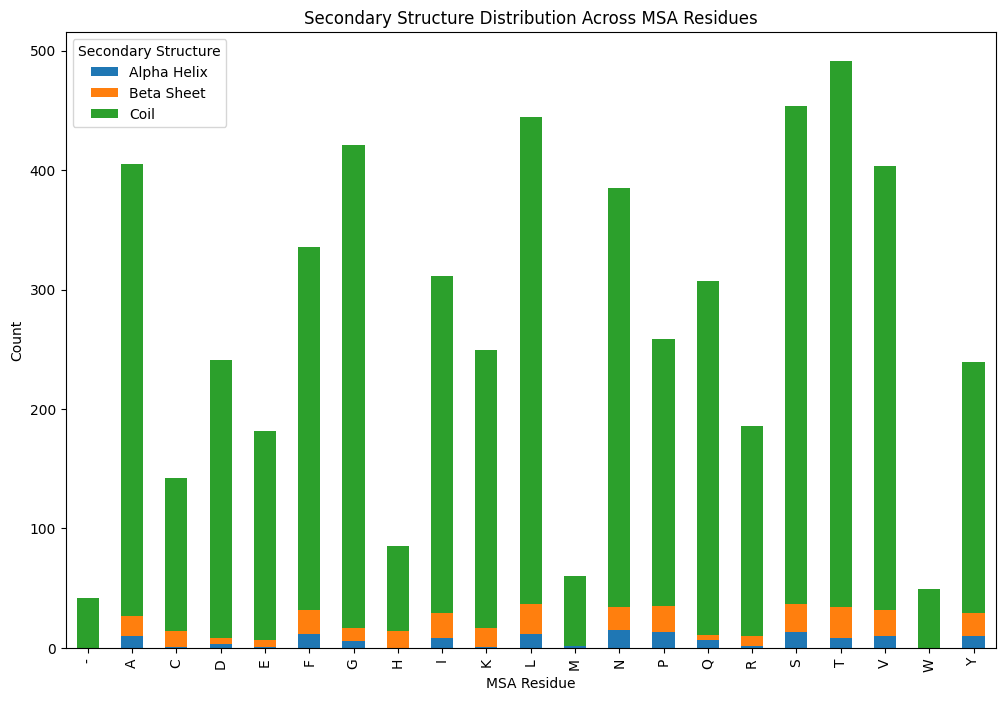

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `dihedral_dfa` is already defined with 'Secondary Structure' and 'MSA Residue' columns

# Step 1: Group by MSA Residue and count the occurrences of each secondary structure type
msa_structure_distribution = dihedral_dfa.groupby(['MSA Residue', 'Secondary Structure']).size().unstack(fill_value=0)

# Print the distribution for inspection
print(msa_structure_distribution)

# Step 2: Visualize the distribution using a stacked bar plot
msa_structure_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Secondary Structure Distribution Across MSA Residues')
plt.xlabel('MSA Residue')
plt.ylabel('Count')
plt.legend(title='Secondary Structure')
plt.show()


In [25]:
# Count occurrences of each secondary structure
secondary_structure_counts = dihedral_dfa['Secondary Structure'].value_counts()

# Display the counts
print("Secondary Structure Counts:")
print(secondary_structure_counts)


Secondary Structure Counts:
Secondary Structure
Coil           5265
Beta Sheet      292
Alpha Helix     134
Name: count, dtype: int64


## Support vector machine

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming dihedral_dfa is already defined as per your provided code

# Convert all column names to strings
dihedral_dfa.columns = dihedral_dfa.columns.astype(str)

# Step 1: Encode the categorical 'MSA Residue' column
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
msa_encoded = encoder.fit_transform(dihedral_dfa[['MSA Residue']])

# Create a DataFrame from the encoded features, converting all column names to strings
msa_encoded_df = pd.DataFrame(msa_encoded, columns=encoder.get_feature_names_out(['MSA Residue']))

# Combine the encoded MSA Residue with the other features (Phi Angle, Psi Angle)
X = pd.concat([msa_encoded_df, dihedral_dfa[['Phi Angle', 'Psi Angle']].reset_index(drop=True)], axis=1)

# Ensure all column names in X are strings
X.columns = X.columns.astype(str)

# Target variable
y = dihedral_dfa['Secondary Structure']

# Step 2: Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Initialize lists to store accuracy for each epoch
train_accuracies = []
test_accuracies = []

# Train the model for 50 epochs
for epoch in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2)  # No random_state
    svm_model = SVC(kernel='rbf')  # No random_state
    svm_model.fit(X_train, y_train)


    # Step 5: Make predictions on the test set
    y_train_pred = svm_model.predict(X_train)
    y_test_pred = svm_model.predict(X_test)

    # Step 6: Evaluate the model's performance
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append the accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Testing Accuracy: {test_accuracy:.2f}\n")

# After the loop, print the final testing accuracy
final_test_accuracy = test_accuracies[-1]
print(f"Final Testing Accuracy after 50 epochs: {final_test_accuracy:.2f}")


Epoch 1:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 2:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 3:
Training Accuracy: 0.92
Testing Accuracy: 0.94

Epoch 4:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 5:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 6:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 7:
Training Accuracy: 0.93
Testing Accuracy: 0.90

Epoch 8:
Training Accuracy: 0.93
Testing Accuracy: 0.91

Epoch 9:
Training Accuracy: 0.92
Testing Accuracy: 0.94

Epoch 10:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 11:
Training Accuracy: 0.92
Testing Accuracy: 0.94

Epoch 12:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 13:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 14:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 15:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 16:
Training Accuracy: 0.92
Testing Accuracy: 0.93

Epoch 17:
Training Accuracy: 0.93
Testing Accuracy: 0.92

Epoch 18:
Training Accu

## Feed Forward Neural Network

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
# Define the parameter grid with updated configurations
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (50, 50), (100, 50), (100, 100)],  # Added (100, 100) for more complex architectures
    'activation': ['tanh', 'relu'],  # Activation function
    'solver': ['adam'],  # Using only 'adam' since it's generally more robust for convergence
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Added 0.1 to explore more regularization options
    'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
    'batch_size': [16, 32, 64, 128],  # Added 128 for larger batch sizes
    'learning_rate_init': [0.001, 0.01, 0.1]  # Added 0.1 to explore different initial learning rates
}


# Initialize the MLPClassifier with more iterations
mlp = MLPClassifier(max_iter=500, random_state=42, warm_start=True, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)


# Setup GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Convert all column names to strings
dihedral_dfa.columns = dihedral_dfa.columns.astype(str)

# Step 1: Encode the categorical 'MSA Residue' column
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
msa_encoded = encoder.fit_transform(dihedral_dfa[['MSA Residue']])

# Create a DataFrame from the encoded features, converting all column names to strings
msa_encoded_df = pd.DataFrame(msa_encoded, columns=encoder.get_feature_names_out(['MSA Residue']))

# Combine the encoded MSA Residue with the other features (Phi Angle, Psi Angle)
X = pd.concat([msa_encoded_df, dihedral_dfa[['Phi Angle', 'Psi Angle']].reset_index(drop=True)], axis=1)

# Ensure all column names in X are strings
X.columns = X.columns.astype(str)

# Target variable
y = dihedral_dfa['Secondary Structure']

# Step 2: Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 3: Perform the train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_model = grid_search.best_estimator_

print("Best parameters found:")
print(grid_search.best_params_)

print("Best cross-validation score:")
print(grid_search.best_score_)

# Step 5: Make predictions on the train and test sets using the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Step 6: Evaluate the model's performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}\n")

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))


## Recurrent Neural Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Dropout

# Assume dihedral_dfa is already defined and contains your data
# Convert all column names to strings
dihedral_dfa.columns = dihedral_dfa.columns.astype(str)

# Encode the categorical 'MSA Residue' column
encoder = OneHotEncoder(sparse_output=False)
msa_encoded = encoder.fit_transform(dihedral_dfa[['MSA Residue']])
msa_encoded_df = pd.DataFrame(msa_encoded, columns=encoder.get_feature_names_out(['MSA Residue']))

# Combine the encoded MSA Residue with the other features (Phi Angle, Psi Angle)
X = pd.concat([msa_encoded_df, dihedral_dfa[['Phi Angle', 'Psi Angle']].reset_index(drop=True)], axis=1)
X.columns = X.columns.astype(str)

# Target variable
y = dihedral_dfa['Secondary Structure']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)  # Convert to one-hot encoding

# Perform the train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

# Reshape X for RNN input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape for RNN (samples, timesteps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape for RNN (samples, timesteps, features)


model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))  # Dropout layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(50, activation='relu'))
model.add(Dense(y_encoded.shape[1], activation='softmax'))


# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Make predictions
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report on Test Set:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))


## Random forest classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume dihedral_dfa is already defined and contains your data
# Convert all column names to strings
dihedral_dfa.columns = dihedral_dfa.columns.astype(str)

# Encode the categorical 'MSA Residue' column
encoder = OneHotEncoder(sparse_output=False)
msa_encoded = encoder.fit_transform(dihedral_dfa[['MSA Residue']])
msa_encoded_df = pd.DataFrame(msa_encoded, columns=encoder.get_feature_names_out(['MSA Residue']))

# Combine the encoded MSA Residue with the other features (Phi Angle, Psi Angle)
X = pd.concat([msa_encoded_df, dihedral_dfa[['Phi Angle', 'Psi Angle']].reset_index(drop=True)], axis=1)
X.columns = X.columns.astype(str)

# Target variable
y = dihedral_dfa['Secondary Structure']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Perform the initial train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

# Initialize the random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Number of 'epochs'
epochs = 50

# Split the training data into different bits for each epoch
for epoch in range(epochs):
    # Shuffle and split the training data into a random subset
    X_train_epoch, _, y_train_epoch, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=epoch)
    
    # Fit the model on the subset of data
    model.fit(X_train_epoch, y_train_epoch)
    
    # Evaluate the model on the full test set
    test_accuracy = model.score(X_test, y_test)
    
    print(f"Epoch {epoch + 1}/{epochs} - Test Accuracy: {test_accuracy:.2f}")

# Make final predictions
y_test_pred = model.predict(X_test)

# Print final classification report
print("\nFinal Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


